<a href="https://colab.research.google.com/github/cse97/Udemy-courses/blob/main/2_RNN_LSTM_TimeSeriesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Perform standard imports**

In [63]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


**Load the dataset**

In [65]:
df = pd.read_csv('/content/S4248SM144NCEN.csv',index_col=0,parse_dates=True)

In [66]:
df.dropna(inplace=True) # To drop any null value if present

In [67]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [68]:
df.tail()

,S4248SM144NCEN
DATE,
2020-06-01,16215
2020-07-01,15757
2020-08-01,15400
2020-09-01,15644
2020-10-01,16343


**Plotting time series data**

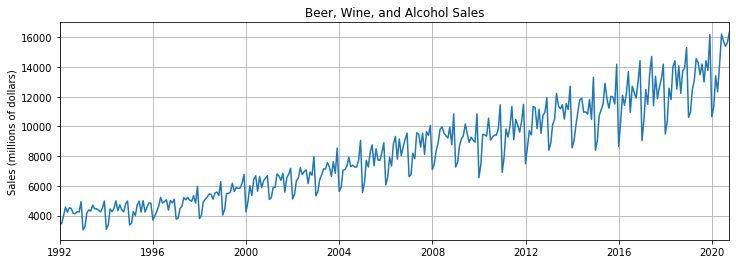

In [69]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True) # To tighten the x-axis to fit width of actual data 
plt.plot(df['S4248SM144NCEN'])
plt.show()


**Prepare the data**


    divide data into train/test sets
    normalize values within -1 and 1 (normalize then min/max feature scaling)
    train the model
    predict into time period that matches test set
    inverse_transform the predicted values so that we can compare them to the actual test data
    forecast into unknown future




   





In [70]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

In [71]:
# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

**Normalize the data**
1.  The formula for normalizing data around zero is: X_{norm} = {X - meu} /{sigma} where meu is the population mean, and sigma is the population standard deviation.
2.  The formula for min/max feature scaling is: X' = a + [{(X - X_min)(b - a)} / (X_max - X_min)] where a=-1 and b=1

In [72]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [73]:
# Normalize the training set (train_norm.min() is -1.0 and train_norm.max() is 1.0)
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

**Prepare data for LSTM**

In [74]:
type(train_norm)

numpy.ndarray

In [75]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

In [76]:
# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # [len(df)- test_size - window_size] = [346-12-12]

322

**Define the model**
    LSTM layer size: (1,100)

In [77]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

**Instantiate the model, define loss and optimization functions**

In [78]:
torch.manual_seed(101)
model = LSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [79]:
# To find no. of parameters
for p in model.parameters():
  print(p.numel())

400
40000
400
400
100
1


**Train the model**

In [86]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch} Loss: {loss.item()}')

total_time = time.time() - start_time
print(f'total time: {total_time/60}')

Epoch: 0 Loss: 0.0012701035011559725
Epoch: 1 Loss: 0.001164127141237259
Epoch: 2 Loss: 0.002050443785265088
Epoch: 3 Loss: 9.340209362562746e-05
Epoch: 4 Loss: 0.00016293129010591656
Epoch: 5 Loss: 0.0005692843114957213
Epoch: 6 Loss: 0.0012769356835633516
Epoch: 7 Loss: 7.076481415424496e-05
Epoch: 8 Loss: 0.0006706374115310609
Epoch: 9 Loss: 0.00877836998552084
Epoch: 10 Loss: 0.0015485798940062523
Epoch: 11 Loss: 0.003426183480769396
Epoch: 12 Loss: 3.055914567084983e-05
Epoch: 13 Loss: 8.907381925382651e-06
Epoch: 14 Loss: 0.0014719332102686167
Epoch: 15 Loss: 0.0002329743729205802
Epoch: 16 Loss: 2.645092536113225e-05
Epoch: 17 Loss: 3.218147685402073e-05
Epoch: 18 Loss: 0.002650957088917494
Epoch: 19 Loss: 0.00045327190309762955
Epoch: 20 Loss: 0.000211654813028872
Epoch: 21 Loss: 0.0014674043050035834
Epoch: 22 Loss: 0.00012281321687623858
Epoch: 23 Loss: 1.882467586256098e-05
Epoch: 24 Loss: 4.840294877794804e-06
Epoch: 25 Loss: 4.6619279601145536e-05
Epoch: 26 Loss: 2.0980958

**Run predictions and compare to known test set**

In [81]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [82]:
# Display predicted values
preds[window_size:]

[0.8135887980461121,
 0.8684264421463013,
 0.28442448377609253,
 0.37558746337890625,
 0.6554138660430908,
 0.7916757464408875,
 0.8609163761138916,
 0.777839183807373,
 0.7583811283111572,
 0.8049755096435547,
 0.7620063424110413,
 0.815300703048706]


**Invert the normalization**

In [83]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[14163.71483681],
       [14500.33571512],
       [10915.43969366],
       [11475.04364395],
       [13192.75801671],
       [14029.20156953],
       [14454.23517478],
       [13944.2658298 ],
       [13824.82255614],
       [14110.84216595],
       [13847.07593289],
       [14174.22336566]])

In [84]:
df['S4248SM144NCEN'][-12:] # last 12 true correct values similar to previous predicted values

DATE
2019-11-01    13773
2019-12-01    16197
2020-01-01    10659
2020-02-01    11350
2020-03-01    13410
2020-04-01    12334
2020-05-01    14111
2020-06-01    16215
2020-07-01    15757
2020-08-01    15400
2020-09-01    15644
2020-10-01    16343
Name: S4248SM144NCEN, dtype: int64

**Plot the results**

In [89]:
# We can create a range of dates using NumPy that are spaced one month apart using dtype='datetime64[M]', and then store them with day values to match our dataset with .astype('datetime64[D]').
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
       '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
       '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01'],
      dtype='datetime64[D]')

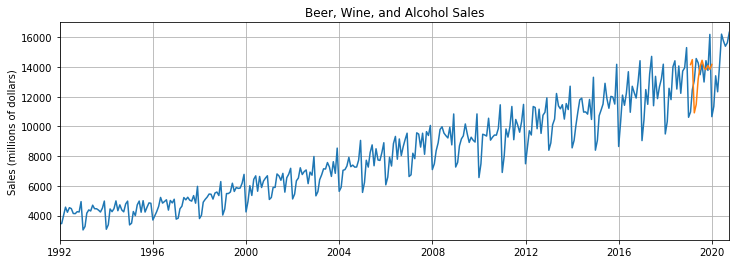

In [90]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

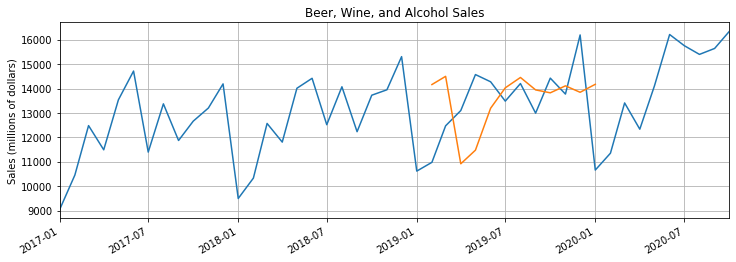

In [91]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

**Forecast into an unknown future**
    training the model using the entire dataset, and predict 12 steps into the future.

In [92]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch} Loss: {loss.item():}')

total_time = time.time() - start_time
print(f'future total time: {total_time/60}')

Epoch: 0 Loss: 0.14058445394039154
Epoch: 1 Loss: 0.05836634337902069
Epoch: 2 Loss: 0.00899740494787693
Epoch: 3 Loss: 0.0075581991113722324
Epoch: 4 Loss: 0.002367271576076746
Epoch: 5 Loss: 0.004023215267807245
Epoch: 6 Loss: 0.0003426680632401258
Epoch: 7 Loss: 0.00013403820048552006
Epoch: 8 Loss: 1.7132663288066396e-06
Epoch: 9 Loss: 4.0395718770014355e-08
Epoch: 10 Loss: 0.0022393863182514906
Epoch: 11 Loss: 0.00533163920044899
Epoch: 12 Loss: 0.02277199923992157
Epoch: 13 Loss: 0.018825557082891464
Epoch: 14 Loss: 0.028810884803533554
Epoch: 15 Loss: 0.01110533345490694
Epoch: 16 Loss: 0.0005632844986394048
Epoch: 17 Loss: 1.5107360695765237e-07
Epoch: 18 Loss: 0.00039554850081913173
Epoch: 19 Loss: 0.00018055384862236679
Epoch: 20 Loss: 0.0020941118709743023
Epoch: 21 Loss: 0.00866180844604969
Epoch: 22 Loss: 0.008378061465919018
Epoch: 23 Loss: 4.2973766539944336e-05
Epoch: 24 Loss: 0.0007534449687227607
Epoch: 25 Loss: 3.879206633428112e-05
Epoch: 26 Loss: 0.0006811187486164

**Predict future values, plot the result**

In [93]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

In [95]:
# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

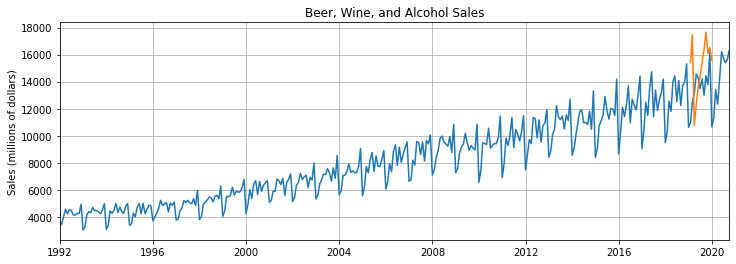

In [96]:
# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

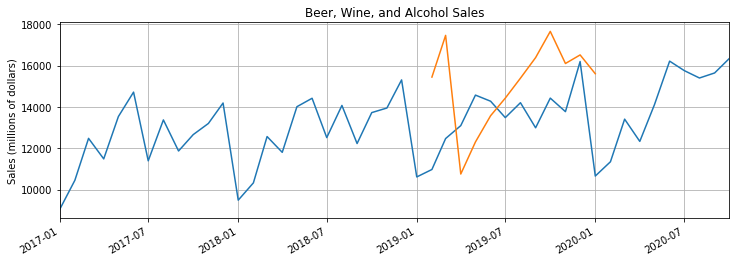

In [97]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()